<hr style="height:0px; visibility:hidden;" />

<h1><center><b>GL4U: RNAseq<b></center></h1>

# Pipeline for Processing GeneLab RNA-sequencing Data

> **The 2 GL4U RNAseq Jupyter Notebooks (JNs) are designed to teach students how to process RNA sequencing data using the GeneLab standard pipeline. Below are step-by-step instructions for processing samples derived from the soleus (aka "anti-gravity") muscle of mice that were either flown in space aboard the International Space Station (ISS) (spaceflight, FLT, animals) or kept in an environmental simulator on Earth to serve as ground controls (GC, animals) during NASA's Rodent Research - 1 mission. More information about the samples analyzed here can be found in the [Open Science Data Repository](https://osdr.nasa.gov/bio/repo) under [OSD-104](https://osdr.nasa.gov/bio/repo/data/studies/OSD-104).**  

---

### RNAseq Pipeline Overview
> This JN will cover the pipeline steps outlined in red. For more information about how GeneLab processes bulk RNAseq data, visit the [GeneLab Data Processing GitHub repository](https://github.com/nasa/GeneLab_Data_Processing/tree/master/RNAseq).  

<br>

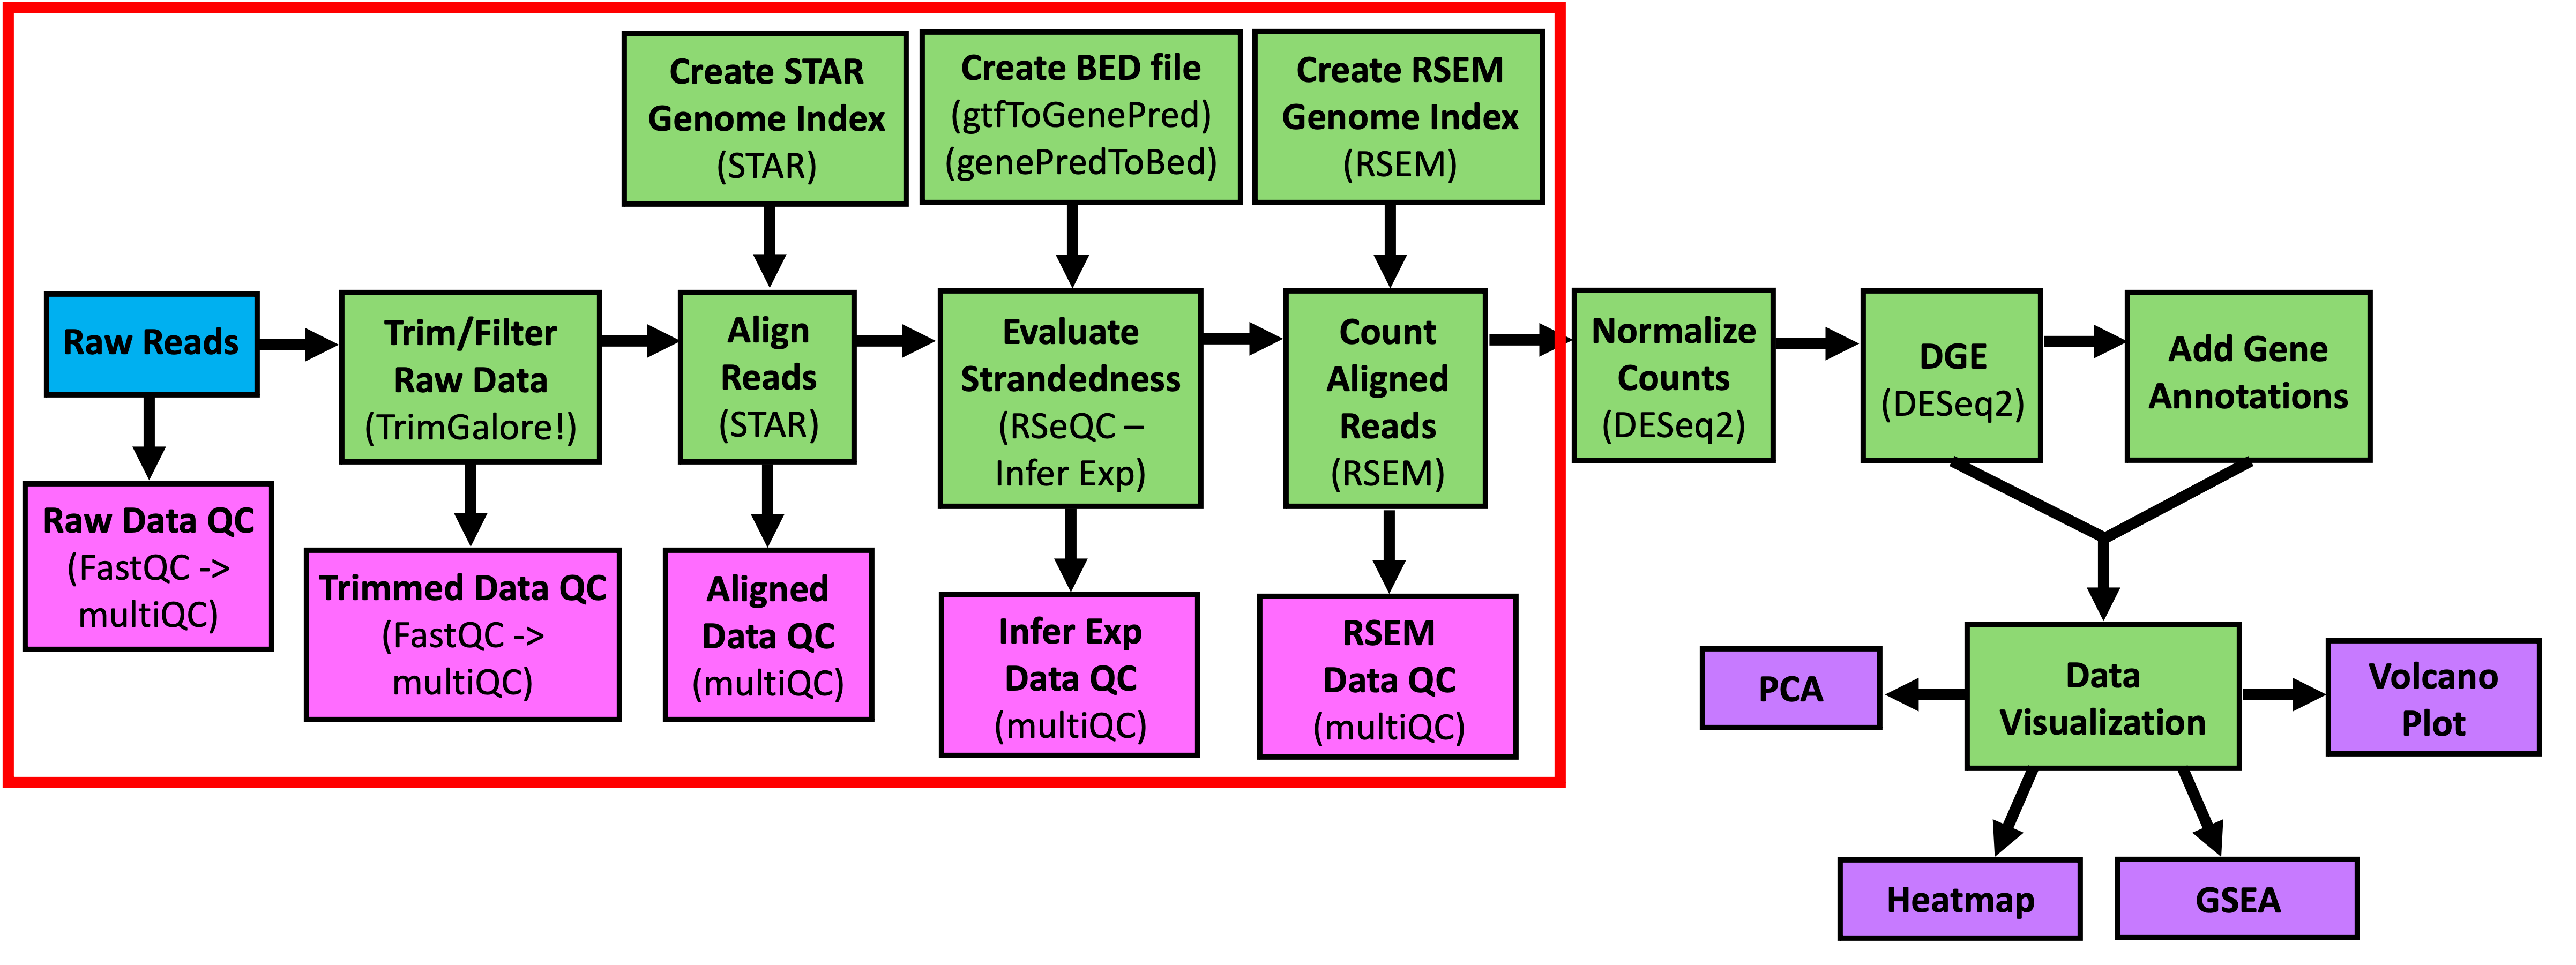


<hr style="height:0px; visibility:hidden;" />
    
<h1><center>1. RNAseq processing: fastq to counts</center></h1>

<div class="alert alert-block alert-success">
Here we are going to setup a directory structure to store the output data we'll generate, then we will follow the steps in the GeneLab standard RNAseq processing pipeline to generate raw count data. All of these steps are most easily done at a Unix-like command line, so this notebook uses a "Bash" kernel, a common language used in a Unix-like environment. 
</div>

---

This is notebook 1 of 2 of GL4U's RNAseq Module Set. It is expected that GL4U's Introduction Module Set has been completed already. 

---

<div style="text-align: right"><a href="02-RNAseq_analysis.ipynb"><b>Next:</b> 2. RNAseq analysis</a></div>

---
---

# Table of Contents

* [0. Setup](#0.-Setup) 
* [1. Raw Data Quality Control (QC)](#1.-Raw-Data-Quality-Control-(QC)) 
    * [1a. Raw Data QC with FastQC](#1a.-Raw-Data-QC-with-FastQC) 
    * [1b. Compile Raw Data QC with MultiQC](#1b.-Compile-Raw-Data-QC-with-MultiQC) 
* [2. Trim/Filter Raw Data](#2.-Trim/Filter-Raw-Data) 
    * [2a. Trim and Filter Raw Sequence Data with Trim Galore!](#2a.-Trim-and-Filter-Raw-Sequence-Data-with-Trim-Galore!) 
    * [2b. Trimmed Data QC with FastQC](#2b.-Trimmed-Data-QC-with-FastQC) 
    * [2c. Compile Trimmed Data QC with MultiQC](#2c.-Compile-Trimmed-Data-QC-with-MultiQC) 
* [3. Build a STAR Index for the Reference Genome](#3.-Build-a-STAR-Index-for-the-Reference-Genome) 
* [4. Align Reads to the Reference Genome](#4.-Align-Reads-to-the-Reference-Genome) 
    * [4a. Align Trimmed Sequence Data with STAR](#4a.-Align-Trimmed-Sequence-Data-with-STAR) 
    * [4b. Compile Alignment Log Files with MultiQC](#4b.-Compile-Alignment-Log-Files-with-MultiQC) 
    * [4c. Index Genome Aligned Reads](#4c.-Index-Genome-Aligned-Reads) 
* [5. Create a BED File for the Reference Genome](#5.-Create-a-BED-File-for-the-Reference-Genome) 
* [6. Determine Read Strandedness](#6.-Determine-Read-Strandedness) 
    * [6a. Evaluate Strandedness with RSeQC Infer Experiment](#6a.-Evaluate-Strandedness-with-RSeQC-Infer-Experiment)
    * [6b. Compile Strandedness Data with MultiQC](#6b.-Compile-Strandedness-Data-with-MultiQC) 
* [7. Build a RSEM Index for the Reference Genome](#7.-Build-a-RSEM-Index-for-the-Reference-Genome) 
* [8. Quantitate Alignment Data](#8.-Quantitate-Alignment-Data) 
    * [8a. Count Aligned Reads with RSEM](#8a.-Count-Aligned-Reads-with-RSEM) 
    * [8b. Compile Count Data with MultiQC](#8b.-Compile-Count-Data-with-MultiQC) 

<a id="setup"></a> 

## 0. Setup

We'll start by moving to the location that contains the files we will use in this JN: 

In [ ]:
cd /workspace/GeneLab-Training/
pwd

**Let's see the directory and all sub-directories that we will be using:**
> During RNAseq processing, you will generate several, likely 100s, of files so it is important to keep the quality control (QC) and processed data files organized. Below, you'll see the directory structure we use at GeneLab to keep our files organized.

<div class="alert alert-block alert-info">
<b>Note:</b><br>

For the purposes of this bootcamp we are only using a subset of the [OSD-104](https://osdr.nasa.gov/bio/repo/data/studies/OSD-104) RNAseq raw reads from the spaceflight (FLT) and respective ground control (GC) soleus muscle samples prepared using the ribo-depletion library preparation method.

</div>

In [ ]:
find ./OSD-104 -maxdepth 3 -type d | sort

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
<br>
    
- `find`   - the primary command we're using, which can be used to look for directories and files
    - `./OSD-104`   - this is a positional argument that tells `find` to search in the "OSD-104" folder that is in our current working directory 
    - `-type d`   - this specifies what we're looking for, the d indicates "directories"
    - `-maxdepth 3` - this tells find to only list directories up to 3 levels deep
- `| sort` - directs the output from the find command into the sort command using a pipe
  
</div>

<a class="anchor" id="paths"></a>

### Define Paths to GL4U: RNAseq Bootcamp Processed Data

To save time and conserve resources, some of the processing steps below will utilize processed data that have already been generated for this course and made available in the directory structure we observed with the command above. Run the following commands to set up variables that define the paths to those files:

In [ ]:
metadata=/workspace/GeneLab-Training/OSD-104/Metadata
raw_fastq=/workspace/GeneLab-Training/OSD-104/00-RawData/Fastq
raw_fastqc=/workspace/GeneLab-Training/OSD-104/00-RawData/FastQC_Reports
raw_multiqc=/workspace/GeneLab-Training/OSD-104/00-RawData/FastQC_Reports/raw_multiqc_report
trimmed_fastq=/workspace/GeneLab-Training/OSD-104/01-TG_Preproc/Fastq
trimmed_fastqc=/workspace/GeneLab-Training/OSD-104/01-TG_Preproc/FastQC_Reports
trimmed_multiqc=/workspace/GeneLab-Training/OSD-104/01-TG_Preproc/FastQC_Reports/trimmed_multiqc_report
STAR_output=/workspace/GeneLab-Training/OSD-104/02-STAR_Alignment
STAR_logs=/workspace/GeneLab-Training/OSD-104/02-STAR_Alignment/Log_files
aligned_multiqc=/workspace/GeneLab-Training/OSD-104/02-STAR_Alignment/aligned_multiqc_report
REFs=/workspace/GeneLab-Training/OSD-104/References
RSeQC_infer_exp=/workspace/GeneLab-Training/OSD-104/RSeQC_analyses/infer_exp
RSeQC_infer_exp_multiqc=/workspace/GeneLab-Training/OSD-104/RSeQC_analyses/infer_exp/infer_exp_multiqc_report
RSEM_output=/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts
RSEM_logs=/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/Log_files
count_multiqc=/workspace/GeneLab-Training/OSD-104/03-RSEM_Counts/count_multiqc_report
processing=/workspace/GeneLab-Training/OSD-104/processing_scripts

There is a file with information about the samples we will be processing in the "Metadata" sub-directory. Let's use the cat command to take a look at that file:

In [ ]:
cat $metadata/OSD-104_Sample_Metadata.csv

The columns are not perfectly aligned across each row when using `cat`. This just has to do with how the print-out is positioning things. 

We can use a command called `column` to help with formatting the print-out (where `-s,` specifies the comma as the delimiter and `-t` tells it to try to make a table):

In [ ]:
column -s, -t $metadata/OSD-104_Sample_Metadata.csv

**Take a look at the OSD-104_Sample_Metadata.csv file above and answer the following questions:**

1. How many samples are there? 
2. How many samples are derived from spaceflight (FLT)? How many from ground control (GC)? How do you know?

**Input your responses to each question in the text boxes below:**

<br> 

<div class="alert alert-block alert-success">

<details>
<summary><b>Solutions</b></summary>

<br>

<b>1.</b> 12 samples<br>
<b>2.</b> 6 samples from FLT and 6 samples from GC, going by what's in the "condition" column
    
</details>
</div>

**Okay, now that we're done with our housekeeping, it's time to start processing RNAseq data!**

<div class="alert alert-block alert-info">
<b>Note:</b><br>

For the purposes of this bootcamp we will only be running one sample, FLT_M23, through each step of the pipeline. 

</div>

---

<a class="anchor" id="rawqc"></a>

## 1. Raw Data Quality Control (QC)

<a class="anchor" id="rawfastqc"></a>

### 1a. Raw Data QC with FastQC

First, we will assess the quality of the raw RNA sequence data using the [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) program. Short-read sequence data are stored in fastq files, which contain several (often millions) of reads. Each read consists of the following 4 line structure:

 > Line 1 - Begins with @, followed by information about the sequencing run such as the sequencing platform, run number, flow cell ID and cluster location, read number (forward/reverse), and/or the sample index.
 <br>
 > Line 2 - Contains the sequence, written as base calls (A, T, C, or G). Note that the sequence length is equal to the number of cycles in the sequencing run.
 <br>
 > Line 3 - A separator line, which begins with a plus (+) sign.
 <br>
 >Line 4 - Quality scores of each base call that are Phred +33 encoded and use [ASCII characters](http://drive5.com/usearch/manual/quality_score.html) to represent the quality of the bases. 

Let's take a look at the raw fastq files we will be using:

In [ ]:
ls -1 $raw_fastq/

Now, let's look at the first couple reads of the forward (R1) fastq file for sample FLT_M23:
> Note: The `zcat` command is similar to the `cat` command we learned in the Unix intro, but it will uncompress gzipped files first then print the contents.

In [ ]:
zcat $raw_fastq/FLT_M23_R1_raw.fastq.gz | head -n 8

It would be difficult to determine the quality of sequence data if we had to interpret the individual quality score for each base of each read of a file. Luckily we don't have to!

FastQC will evaluate the information provided for each read in the fastq files and generate a summary report about the quality of the sequence data. Assessing the raw sequence quality is important for determining if and how the reads need to be trimmed.

Let's run FastQC on the raw reads of our FLT_M23 sample using the following command:

In [ ]:
fastqc -o $raw_fastqc $raw_fastq/*raw.fastq.gz

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `-o` – the output directory to store the FastQC results
* `*raw.fastq.gz` – the input reads are specified as a positional argument, and can be given all at once with wildcards, or as individual arguments with spaces in between them

**Input Data:**
- *raw.fastq.gz (raw reads)

**Output Data:**
- *fastqc.html (FastQC report: a webpage file containing graphical representations of the raw sequence quality)
- *fastqc.zip (FastQC data: a compressed directory containing the quality reports of all raw sequences assessed)

</div>

___________

The fastqc job is complete when you see the "Analysis complete for" statement for both the forward (R1) and reverse (R2) files of our sample. 

Let's list the output files that were generated:

In [ ]:
ls -1 $raw_fastqc/FLT_M23*

You can use the paths indicated above to navigate to the FastQC outputs for sample FLT_M23 on the left side panel. Then double click on the "FLT_M23_R1_raw_fastqc.html" or "FLT_M23_R2_raw_fastqc.html" files to open up the FastQC reports.

<div class="alert alert-block alert-info">
<b>Note:</b><br>

As we covered earlier, there are many modules included in the `fastqc` program, with the documentation for each linked on [this page](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/). While these are summarized in a pass (green check), warning (yellow exclamation point), and fail (red X) fashion, it is important to remember that those indicators are based on expecting the data are completely random and diverse, which is often not the case depending on the type of sequencing that was done.

</div>

<a class="anchor" id="rawmultiqc"></a>

### 1b. Compile Raw Data QC with MultiQC

Rather than viewing the FastQC reports of each fastq file for all 12 samples individually, we can use the [MultiQC](https://docs.seqera.io/multiqc) program to compile the FastQC data from all samples and generate a single report (and associated data files). This allows us to view and assess the raw sequence data of all samples at once. 

Let's compile the raw FastQC data from our 12 samples using MultiQC by running the following command:

In [ ]:
multiqc --interactive -n raw_multiqc -o $raw_multiqc $raw_fastqc/

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `--interactive` – force reports to use interactive plots
* `-n` – prefix name for the output files
* `-o` – specifies the output directory to store the MultiQC results
* `$raw_fastqc/` – the directory holding the raw FastQC data from each sample, provided as a positional argument

**Input Data:**
- *fastqc.zip (FastQC data)

**Output Data:**
- raw_multiqc_data (directory containing the compiled raw FastQC data from each sample, used to create the MultiQC report)
- raw_multiqc.html (multiqc report: an interactive webpage file containing graphical representations of the compiled raw sequence quality)

</div>

___________

The multiQC job is complete when you see the "MultiQC complete" statement at the end of the standard output. Check that the number of reports found matches what you expect.
> Note: For paired-end data, we expect a report for both the forward (R1) and reverse (R2) reads of each sample. Since we have 12 paired-end samples, MultiQC should detect 24 FastQC reports.

Let's list the output files that were generated:

In [ ]:
ls -1 $raw_multiqc/

Use the path indicated above to navigate to the MultiQC report generated from the raw FastQC data on the left side panel. Then double click on the "raw_multiqc.html" file to open up the compiled FastQC reports from all 12 samples.

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
Click [here](https://docs.seqera.io/multiqc/modules/fastqc) for a description of the MultiQC plots derived from FastQC data

</div>

<div class="alert alert-block alert-warning">
<a class="anchor" id="enableJS"></a>

##### Enable JavaScript
    
Be sure to click the "Trust HTML" button in the top left corner of the MultiQC report to be able to see all the plots.

If the plots are still not visible, make sure JavaScript is enabled on the web-browser you are using. Below are instructions for how to enable JavaScript on common web-browsers:
- Google Chrome:
  - Click the three-dot menu in the top right corner and go to Settings.
  - Scroll down and click Privacy and security on the left.
  - Select Site Settings.
  - Scroll down to JavaScript and make sure it's set to Allowed.
- Mozilla Firefox:
  - Type about:config in the address bar and press Enter.
  - Click the "Accept the Risk and Continue" button.
  - In the search bar, type javascript.enabled.
  - Ensure the value is set to true. If it's false, double-click to change it to true.
- Microsoft Edge:
  - Click the three-dot menu in the top right corner and go to Settings.
  - Scroll down and select Cookies and site permissions.
  - Under Site permissions, click JavaScript.
  - Make sure the toggle is set to Allowed.
- Safari (Mac):
  - Open the Safari menu and select Preferences.
  - Go to the Security tab.
  - Make sure the checkbox Enable JavaScript is checked.

</div>

**Take a look at the multiQC report of the raw fastQC data above and answer the following questions:**

1. Which sample was sequenced at the greatest read depth? the least read depth? (Hint: See *M Seqs* under "General Statistics")
2. What do you notice about the quality of the raw sequence data? Are there any differences between the forward and reverse reads?
3. Were adapters detected?
4. Should we trim and/or filter the data before aligning to the reference genome? Why or why not?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

All samples show the same read depth, 0.1M reads.
> *Note: This is because these reads were purposfully truncated to 100,000. Normally you'll find that samples have different read depths. In RNAseq studies, it is important for samples to be sequenced at similar depths to enable downstream gene expression comparisons.* 
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The quality is overall good (>Q25).  
    
The reverse reads have slightly lower quality than the forward reads.
> This may be due to the fact that the reverse reads are sequenced after the forward reads. Therefore the template cDNA and/or the reagents may have degraded slightly, reducing the quality of the reverse reads.
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

Yes, Illumina Universal Adapters are detected towards the end of some reads for every sample, although they make up less than 2% of the total reads for each sample.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

While these data look pretty good overall, it is still a good idea to trim/filter them to remove the adapters and since these quality plots only show the averages, there may be some reads with poor quality we might still want to filter out. 

</details>
</div>


---

<a class="anchor" id="trimfilter"></a>

## 2. Trim/Filter Raw Data

<a class="anchor" id="trim"></a>

### 2a. Trim and Filter Raw Sequence Data with Trim Galore! 

To ensure maximal sequence alignment to the reference genome, our next step is to clean up the raw sequence data using [TrimGalore!](https://www.bioinformatics.babraham.ac.uk/projects/trim_galore/), which utilizes the [cutadapt](https://cutadapt.readthedocs.io/en/stable/) software. During this step, we filter the raw reads to remove any sequencing adapters detected, which were artificially added to enable sequencing of the sample RNA, as well as low-quality base calls and reads that become too short after trimming.

Any idea why we would want to do this before aligning to the reference genome?

**Input your response to the question in the text box below:**

<br> 

<div class="alert alert-block alert-success">

<details>
<summary><b>Answer</b></summary>

<br>

Removing any bases that were artificially added and thus were not generated from the organism’s DNA (represented by the reference genome), will improve the quality of alignment.

</details>
</div>

Let's see how this is done by trimming the forward (R1) and reverse (R2) reads of sample FLT_M23 with TrimGalore! using the following command:


In [ ]:
trim_galore --gzip \
 --cores 2 \
 --phred33 \
 --paired \
 --output_dir $trimmed_fastq \
 $raw_fastq/FLT_M23_R1_raw.fastq.gz $raw_fastq/FLT_M23_R2_raw.fastq.gz

The suffixes added to the trimmed fastq output files by TrimGalore! are not very intuitive so the GeneLab pipeline renames them as follows: 

In [ ]:
mv $trimmed_fastq/FLT_M23_R1_raw_val_1.fq.gz $trimmed_fastq/FLT_M23_R1_trimmed.fastq.gz
mv $trimmed_fastq/FLT_M23_R2_raw_val_2.fq.gz $trimmed_fastq/FLT_M23_R2_trimmed.fastq.gz

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>


**Parameter Definitions:**

* `--gzip` – compress the output files with `gzip`
* `--cores` – specifies the number of compute cores to use 
* `--phred33` - instructs cutadapt to use ASCII+33 quality scores as Phred scores for quality trimming
* `--paired` - indicates paired-end reads - both reads, forward (R1) and reverse (R2) must pass length threshold or else both reads are removed (if not defined, a 20bp length threshold is applied)
* `--output_dir` - the output directory to store the trimmed fastq and respective trimming report files
* `$raw_fastq/${sample}_R1_raw.fastq.gz $raw_fastq/${sample}_R2_raw.fastq.gz` – the input reads are specified as a positional argument, paired-end read files are listed pairwise such that the forward reads (\*R1_raw.fastq.gz) are immediately followed by the respective reverse reads (\*R2_raw.fastq.gz) for each sample

**Input Data:**
- *raw.fastq.gz (raw reads)

**Output Data:**
- *trimming_report.txt (trimming report: information about how the data were trimmed/filtered)
- *trimmed.fastq.gz (trimmed reads: remaining sequence data after quality, adapter, and read length filtering)

</div>

___________

Let's list the output files that were generated:

In [ ]:
ls -1 $trimmed_fastq/

Let's view the trimming reports for both the forward (R1) and reverse (R2) read data from sample FLT_M23:

In [ ]:
echo "Forward trimming report:"
cat $trimmed_fastq/FLT_M23_R1_raw.fastq.gz_trimming_report.txt
echo ""
echo "Reverse trimming report:"
cat $trimmed_fastq/FLT_M23_R2_raw.fastq.gz_trimming_report.txt

____

**Take a look at the === Summary === section of both the forward and reverse read trimming reports and answer the following questions:**

1. How many forward reads were processed? How many reverse reads?
2. Are the total number of forward and reverse reads processed the same or different? Should these numbers be the same? Why? 
3. Were any adapters detected in the forward or reverse reads? If yes, how many forward reads contained adapters? How many reverse reads contained adapters? 
4. After adapters were trimmed from the forward and reverse reads, were any reads removed? Why?
5. How many basepairs were removed due to poor quality in the forward reads? What about the reverse reads?
6. After adapter trimming and quality filtering, what is the total number and percent of basepairs remaining for the forward reads? What about the reverse reads?
7. Did the raw forward or raw reverse reads have better quality? How do you know?

**Look at the bottom of the reverse read trimming report and answer the following questions:**

8. After trimming and filtering, did any read pairs fail to meet the 20bp read length cutoff? If yes, how many?
9. Why is this information only contained in the reverse read trimming report?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Number of forward reads processed: 100,000
Number of reverse reads processed: 100,000

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

The total number of forward and reverse reads processed are the same.

They should be the same because the same cDNA fragment was sequenced in the forward and reverse directions.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

Yes, adapters were detected in both the forward and reverse reads.
Number of forward reads with adapters: 31,739 (31.7%)
Number of reverse reads with adapters: 32,132 (32.1%)

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

No reads were removed after adapter trimming because after removing basepairs due to adapter contamination, all forward and reverse reads still contained basepairs. 

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q5 Solution</b></summary>

<br>

Basepairs removed due to poor quality in the forward reads: 7,848 bp (0.1%)
Basepairs removed due to poor quality in the reverse reads: 49,988 bp (0.5%)
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q6 Solution</b></summary>

<br>

Total amount of basepairs remaining in the forward reads: 9,893,689 bp (98.9%)
Total amount of basepairs remaining in the reverse reads: 9,849,322 bp (98.5%)
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q7 Solution</b></summary>

<br>

Forward reads had better quality because fewer base pairs were removed due to adapter contamination and/or poor quality.
> Note: Read quality can also be determined by the multiqc report of the raw fastqc data as discussed above.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q8 Solution</b></summary>

<br>

Yes, 89 (0.09%) of read pairs failed to meet the 20bp read length cutoff. 

</details>
</div>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q9 Solution</b></summary>

<br>

This information is only contained in the reverse read trimming report because the number of forward and reverse reads have to be the same. So, the if the forward read of a fragment was 40bp after trimming (passing the 20bp cutoff) but the respective reverse read of that same fragment was 19bp after trimming (failing the 20bp cutoff) then both the forward and reverse read for the fragment must be removed.

</details>
</div>


<br>


<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
To preserve compute resources, raw sequence data for all samples have been trimmed with these parameters and the resulting trimmed reads will be used for the following steps.

</div>

<br>

---

<br>

<a class="anchor" id="trimmedfastqc"></a>

### 2b. Trimmed Data QC with FastQC

Now that we've trimmed/filtered our raw sequence data, we will assess the quality of the trimmed sequence data using [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) to evaluate how effective trimming was at improving sequence quality.

Let's run FastQC on the trimmed reads of our FLT_M23 sample using the following command:

In [ ]:
fastqc -o $trimmed_fastqc $trimmed_fastq/*trimmed.fastq.gz

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `-o` – the output directory to store the FastQC results
* `*trimmed.fastq.gz` – the input reads are specified as a positional argument, and can be given all at once with wildcards, or as individual arguments with spaces in between them

**Input Data:**
- *trimmed.fastq.gz (trimmed reads)

**Output Data:**
- *fastqc.html (FastQC report: a webpage file containing graphical representations of the trimmed sequence quality)
- *fastqc.zip (FastQC data: a compressed directory containing the quality reports of all trimmed sequences assessed)

</div>

---

Let's list the FastQC output files that were generated:

In [ ]:
ls -1 $trimmed_fastqc/FLT_M23*

<br>

You can use the paths indicated above to navigate to the FastQC outputs for sample FLT_M23 on the left side panel. Then double click on the "FLT_M23_R1_trimmed_fastqc.html" or "FLT_M23_R2_trimmed_fastqc.html" files to open up the FastQC reports.

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
To preserve compute resources, the FastQC data and reports have been generated for the forward (R1) and reverse (R2) trimmed fastq files of all OSD-104 FLT and GC samples.

</div>

---
 

<a class="anchor" id="trimmedmultiqc"></a>

### 2c. Compile Trimmed Data QC with MultiQC

Rather than viewing the FastQC reports of each trimmed fastq file for all 12 samples individually, we'll again use the [MultiQC](https://docs.seqera.io/multiqc) program but this time to compile the trimmed FastQC data from all samples and generate a single report (and associated data files). This will allow us to view the trimmed sequence data quality of all samples at once and compare it to the raw sequence data quality. 

Let's compile the trimmed FastQC data from our 12 samples using MultiQC by running the following command:

In [ ]:
multiqc --interactive -n trimmed_multiqc -o $trimmed_multiqc $trimmed_fastqc/

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `--interactive` – force reports to use interactive plots
* `-n` – prefix name for the output files
* `-o` – the output directory to store the MultiQC results
* `$trimmed_fastqc/` – the directory holding the trimmed FastQC data from each sample, provided as a positional argument

**Input Data:**
- *fastqc.zip (trimmed FastQC data)

**Output Data:**
- trimmed_multiqc_data (directory containing the compiled trimmed FastQC data from each sample, used to create the MultiQC report)
- trimmed_multiqc.html (multiqc report: an interactive webpage file containing graphical representations of the compiled trimmed sequence quality)

</div>

___________

The multiQC job is complete when you see the "MultiQC complete" statement at the end of the standard output. Check that the number of reports found matches what you expect.
> Note: For paired-end data, we expect a report for both the forward (R1) and reverse (R2) reads of each sample. Since we have 12 paired-end samples, MultiQC should detect 24 FastQC reports.

Let's list the output files that were generated:

In [ ]:
ls -1 $trimmed_multiqc/*

Use the path indicated above to navigate to the MultiQC report generated from the trimmed FastQC data on the left side panel. Then double click on the "trimmed_multiqc.html" file to open up the compiled FastQC reports from all 12 samples.

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
Click [here](https://docs.seqera.io/multiqc/modules/fastqc) for a description of the MultiQC plots derived from FastQC data

</div>

<div class="alert alert-block alert-warning">

Be sure to click the "Trust HTML" button in the top left corner of the MultiQC report to be able to see all the plots.

If the plots are still not visible, make sure JavaScript is enabled on the web-browser you are using. See [above](#Enable-JavaScript) for instructions to enable JavaScript on common web-browsers.

</div>

___

**Take a look at the multiQC report of the trimmed fastQC data above and answer the following questions:**

1. How many reads are there in the GC_M33 sample after trimming? What about the FLT_M24 sample?  (Hint: See *M Seqs* under "General Statistics")
2. What is the sequencing depth range among samples?  
3. What do you notice about the quality of the trimmed sequence data compared with the raw?
4. Do you still see adapters detected?
5. Do you think we're ready to align the trimmed reads to the reference genome now? Why or why not?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Number of reads in GC_M33 after trimming: 99,858 
Number of reads in FLT_M24 after trimming: 99,879 
> _Note: Since this is a truncated dataset and the "M Seqs" column is rounded to the neareast tenths place, all samples in this dataset will appear to have the same read depth (0.1M). However, you can add up the number of unique + dupe sequences in the "Sequence Counts" section for each sample to get these exact values. Alternatively, you can look at the individual fastqc HTML reports for each sample in the `$trimmed_fastqc` location._
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

99,850 (FLT_M26) - 99,916 (FLT_M28)
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

The trimmed sequence data is better quality than the raw data.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

No, adapters are no longer detected. 

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q5 Solution</b></summary>

<br>

Yes, because the trimmed reads are high quality and do not contain any detectable adapters. 

</details>
</div>


<br>

---

<a class="anchor" id="starindex"></a>

## 3. Build a STAR Index for the Reference Genome

Now that our RNA sequence data is of high quality, our next step is to identify which gene(s) each RNA sequence came from. To do this, we will align the reads back to the reference genome of the organism from which the samples were derived using the [STAR (Spliced Transcripts Alignment to a Reference)](https://github.com/alexdobin/STAR) aligner. 

Since our samples came from the soleus muscle of mice (scientific name _Mus musculus_), we will align the trimmed reads to the _Mus musculus_ reference genome (GRCm39), file `Mus_musculus.GRCm39.dna.primary_assembly.fa` from the ensembl database found [here](http://ftp.ensembl.org/pub/release-112/fasta/mus_musculus/dna/). In addition to the reference genome, we will also need to provide STAR with information about the gene features of all annotated genes in the reference genome. (_Note: Annotated genes are genes whose genomic coordinates and function, i.e. where they are and what they do, are known._) All of the gene feature information STAR needs is provided in the `Mus_musculus.GRCm39.112.gtf` gene transfer format (GTF) file associated with the _Mus musculus_ reference genome (GRCm39) from the ensembl database found [here](http://ftp.ensembl.org/pub/release-112/gtf/mus_musculus/).

> For more information about the ensembl gene transfer format (GTF) and gene feature format (GFF) files, click [here](http://m.ensembl.org/info/website/upload/gff.html)

Before we can align our trimmed reads to the _Mus musculus_ reference genome, the STAR program needs to organize all the information provided in the genome and GTF files to be able to accurately assign each read to the gene from which it came. To do this, we will first run STAR in the `genomeGenerate` mode, which will create a STAR index containing the genome reference and gene feature information in the STAR format. 

<div class="alert alert-block alert-info">
<b>Note:</b><br>

Creating a STAR index requires a lot of compute and storage resources and can take a while to complete, so we did it for you. You're welcome :0)

</div>

The following command was used to generate the STAR index for _Mus musculus_:

```bash
STAR --runThreadN 16 \
 --runMode genomeGenerate \
 --limitGenomeGenerateRAM 70000000000 \
 --genomeDir STAR_index \
 --genomeFastaFiles Mus_musculus.GRCm39.dna.primary_assembly.fa \
 --sjdbGTFfile $genome_gtf/Mus_musculus.GRCm39.112.gtf \
 --sjdbOverhang 99
```


<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `--runThreadN` – number of threads available to create the STAR indexed reference
* `--runMode` - instructs STAR to run genome indices generation job to create the STAR indexed reference
* `--limitGenomeGenerateRAM` - maximum RAM available (in bytes) to generate STAR reference
  > _Note: At least 35GB are needed for mouse and the example above shows 70GB_
* `--genomeDir` - specifies the directory where the STAR indexed reference will be stored
  > _Note: At least 100GB of available disk space is required for mammalian genomes_
* `--genomeFastaFiles` - specifies the uncompressed fasta file containing the genome reference sequences
* `--sjdbGTFfile` – specifies the uncompressed file containing annotated transcripts in the standard GTF format
* `--sjdbOverhang` - indicates the length of the genomic sequence around the annotated junction to be used in constructing the splice junctions database
  > _Note: The length should be one less than the length of the (longest) read_

**Input Data:**
- *.fasta (reference genome sequence)
- *.gtf (reference genome transfer feature file)

**Output Data:**

STAR indexed genome reference, which consists of the following files:
- chrLength.txt
- chrNameLength.txt
- chrName.txt
- chrStart.txt
- exonGeTrInfo.tab
- exonInfo.tab
- geneInfo.tab
- Genome
- genomeParameters.txt
- SA
- SAindex
- sjdbInfo.txt
- sjdbList.fromGTF.out.tab
- sjdbList.out.tab
- transcriptInfo.tab

</div>

<br>

---

<a class="anchor" id="star"></a>

## 4. Align Reads to the Reference Genome

<a class="anchor" id="staralign"></a>

### 4a. Align Trimmed Sequence Data with STAR

We are now ready to align the trimmed reads to the mouse reference genome. This step of determining the genomic location (and ultimately, gene) from which each short sequence was derived is quite challenging. Any ideas why that is?

**Input your response to the question in the text box below:**

<br> 

<div class="alert alert-block alert-success">

<details>
<summary><b>Answer</b></summary>

<br>

- Reads are very short relative to transcripts, and some genomes (including mouse and human) can be quite large and contain lots of non-unique sequences such as pseudogenes, which makes mapping difficult. 
- Aligners also have to cope with mismatches and indels (insertions and deletions) caused by genomic variation and sequencing errors. 
- Many organisms have introns in their genes and therefore, reads align non-contiguously (not touching). Placing spliced reads across introns and determining exon-intron boundaries is difficult, especially considering that introns can be thousands of basepairs long.
    
</details>
</div>

Spliced aligners, including [STAR](https://github.com/alexdobin/STAR), were developed to more accurately identify non-contiguously aligned reads. Additionally, the STAR spliced alignment program is able to perform an unbiased search for splice junctions without needing any prior information on location, sequence signals, or intron length. It is also capable of aligning a read with multiple splice junctions, indels, and mismatches and those with low-quality ends.

In order to improve the detection and quantification of splice sites, we will run STAR in the “two-pass mode”. Here, splice sites are detected in the initial mapping to the reference and used to build a new reference that includes these splice sites. Reads are then re-mapped to this dynamically generated reference to improve the quantification of splice isoforms.

<div class="alert alert-block alert-info">
<b>Note:</b><br>

Aligning trimmed reads with STAR requires a lot of compute and storage resources and can take a while to complete, so we did it for you. You're welcome :0)

</div>


The following `STAR` command was used to align trimmed reads for all 12 samples to the _Mus musculus_ reference: 

```bash
STAR --twopassMode Basic \
 --limitBAMsortRAM 55000000000 \
 --genomeDir STAR_index \
 --outSAMunmapped Within \
 --outFilterType BySJout \
 --outSAMattributes NH HI AS NM MD MC \
 --outFilterMultimapNmax 20 \
 --outFilterMismatchNmax 999 \
 --outFilterMismatchNoverReadLmax 0.04 \
 --alignIntronMin 20 \
 --alignIntronMax 1000000 \
 --alignMatesGapMax 1000000 \
 --alignSJoverhangMin 8 \
 --alignSJDBoverhangMin 1 \
 --sjdbScore 1 \
 --readFilesCommand zcat \
 --runThreadN 18 \
 --outSAMtype BAM SortedByCoordinate \
 --quantMode TranscriptomeSAM GeneCounts \
 --outSAMheaderHD @HD VN:1.4 SO:coordinate \
 --outFileNamePrefix $STAR_output/${sample}/${sample}_ \
 --readFilesIn $trimmed_fastq/${sample}_R1_trimmed.fastq.gz $trimmed_fastq/${sample}_R2_trimmed.fastq.gz
```

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `--twopassMode` – specifies 2-pass mapping mode; the `Basic` option instructs STAR to perform the 1st pass mapping, then automatically extract junctions, insert them into the genome index, and re-map all reads in the 2nd mapping pass
* `--limitBAMsortRAM` - maximum RAM available (in bytes) to sort the bam files, the example above indicates 55GB
* `--genomeDir` - specifies the path to the directory where the STAR indexed reference is stored
* `--outSAMunmapped` - specifies output of unmapped reads in the sam format; the `Within` option instructs STAR to output the unmapped reads within the main sam file
* `--outFilterType` - specifies the type of filtering; the `BySJout` option instructs STAR to keep only those reads that contain junctions that passed filtering in the SJ.out.tab output file
* `--outSAMattributes` - list of desired sam attributes in the order desired for the output sam file
  > _Note: SAM attribute descriptions can be found [here](https://samtools.github.io/hts-specs/SAMtags.pdf)_
* `--outFilterMultimapNmax` – specifies the maximum number of loci the read is allowed to map to; all alignments will be output only if the read maps to no more loci than this value
* `--outFilterMismatchNmax` - maximum number of mismatches allowed to be included in the alignment output
* `--outFilterMismatchNoverReadLmax` - ratio of mismatches to read length allowed to be included in the alignment output; the `0.04` value indicates that up to 4 mismatches are allowed per 100 bases
* `--alignIntronMin` - minimum intron size; a genomic gap is considered an intron if its length is equal to or greater than this value, otherwise it is considered a deletion
* `--alignIntronMax` - maximum intron size
* `--alignMatesGapMax` - maximum genomic distance (in bases) between two mates of paired-end reads
  > _Note: This option should be removed for single-end reads_
* `--alignSJoverhangMin` - minimum overhang (i.e. block size) for unannotated spliced alignments
* `--alignSJDBoverhangMin` - minimum overhang (i.e. block size) for annotated spliced alignments
* `--sjdbScore` - additional alignment score for alignments that cross database junctions
* `--readFilesCommand` - specifies command needed to interpret input files; the `zcat` option indicates input files are compressed with gzip and zcat will be used to uncompress the gzipped input files
* `--runThreadN` - indicates the number of threads to be used for STAR alignment 
* `--outSAMtype` - specifies desired output format; the `BAM SortedByCoordinate` options specify that the output file will be sorted by coordinate and be in the bam format
* `--quantMode` - specifies the type(s) of quantification desired; the `TranscriptomeSAM` option instructs STAR to output a separate sam/bam file containing alignments to the transcriptome and the `GeneCounts` option instructs STAR to output a tab delimited file containing the number of reads per gene
* `--outSAMheaderHD` - indicates a header line for the sam/bam file
* `--outFileNamePrefix` - specifies the path to and prefix for the output file names; for GeneLab the prefix is the sample id
* `--readFilesIn` - path to input read 1 (forward read) and read 2 (reverse read); for paired-end reads, read 1 and read 2 should be separated by a space; for single-end reads only read 1 should be indicated 


**Input Data:**
- STAR indexed reference genome (output from [Step 3](#3.-Build-a-STAR-Index-for-the-Reference-Genome)) 
- *trimmed.fastq.gz (trimmed reads, output from [Step 2a](#2a.-Trim-and-Filter-Raw-Sequence-Data-with-Trim-Galore!))

**Output Data:**

> _Note: Detailed descriptions of all STAR output files can be found in the [STAR manual](https://github.com/alexdobin/STAR/blob/master/doc/STARmanual.pdf) under the "Output files" section._

- *Aligned.sortedByCoord.out.bam (binary, alignment map containing sorted reads mapping to genome)
- *Aligned.toTranscriptome.out.bam (binary, alignment map containing sorted reads mapping to transcriptome)
- *Log.final.out (log file containing a summary of the mapping info/stats such as # reads mapped, etc)
- *ReadsPerGene.out.tab (tab-delimited file containing STAR read counts per gene with 4 columns that correspond to different strandedness options: column 1 = gene ID, column 2 = counts for unstranded RNAseq, column 3 = counts for 1st read strand aligned with RNA, column 4 = counts for 2nd read strand aligned with RNA)
- *Log.out (log file containing detailed information about the mapping run, useful for troubleshooting)
- *Log.progress.out (file containing the job progress statistics that is updated every minute during the mapping run)
- *SJ.out.tab (tab-delimited file containing identified splice junctions and respective count data)
- *_STARgenome (directory containing the extracted junctions from the 1st pass mapping that was inserted into the genome index)
  - sjdbInfo.txt
  - sjdbList.out.tab
- *_STARpass1 (directory containing splice junction and summary mapping info/stats from the 1st pass mapping)
  - Log.final.out
  - SJ.out.tab
- *_STARtmp (directory containing subdirectories that are empty – this was the location for temp files that were automatically removed after successful completion)
  - BAMsort
 
</div>

___

Let's take a look at the first few lines of the *Aligned.toTranscriptome.out.bam output file from sample FLT_M23 using the following command:

<div class="alert alert-block alert-info">
<b>Note:</b><br>

BAM files are compressed, binary versions of Sequence Alignment/Map (SAM) files and need to be uncompressed using `samtools view` to view the file contents.

</div>

In [ ]:
samtools view $STAR_output/FLT_M23/FLT_M23_Aligned.toTranscriptome.out.bam | head

<div class="alert alert-block alert-info">
<b>SAM file content</b><br>

All BAM/SAM files contain at least the following 11 tab-separated fields in order of column location:

1) **QNAME** - Query template name: Info about the sequencing run that generated the read, found in line 1 of the trimmed fastq file as described in [Step 1a](#1a.-Raw-Data-QC-with-FastQC) above. 

2) **FLAG** - bitwise FLAG: Information about the alignment encoded in bits. To easily decode the SAM FLAG, type it into the Broad Institute's SAM FLAG decoder [here](https://broadinstitute.github.io/picard/explain-flags.html)

3) **RNAME** - Reference sequence name: Name of the reference sequence the read aligned to (this will be the ensembl transcript ID in the transcript-aligned BAM file as shown above, and the chromosome number in the genome-aligned BAM file)

4) **POS** - 1-based leftmost mapping position: The position on the reference genome in which the left most base of the read aligns.

5) **MAPQ** - Mapping quality: Equality to the -10log(base10) of the probability that the mapping position is wrong; a value of 255 indicates that the mapping quality is not available.

6) **CIGAR** - CIGAR string: Aligned read length and associated operation, which encodes information about the alignment relative to the reference (i.e. match/mismatch, insertion/deletion).

7) **RNEXT** - Reference name of the mate/next read: Reference sequence name of the next aligned read in the template, if it's the same, this is represented with an equal (=) sign.

8) **PNEXT** - Position of the mate/next read: 1-based position of the next aligned read in the template.

9) **TLEN** - Observed template length: Length from the leftmost position of read 1 to the rightmost position of read 2 for aligned paired-end sequence data.

10) **SEQ** - Segment sequence: Sequence of the aligned trimmed read, found in line 2 of the trimmed fastq file as described in [Step 1a](#1a.-Raw-Data-QC-with-FastQC) above.

11) **QUAL** - ASCII of Phred-scaled base quality +33: Base call quality scores, found in line 4 of the trimmed fastq file as described in [Step 1a](#1a.-Raw-Data-QC-with-FastQC) above.

12+) Additional SAM attributes that were added with the `--outSAMattributes` option in the STAR alignment command above.

> _Detailed descriptions of the Sequence Alignment/Map (SAM) format specification can be found [here](https://samtools.github.io/hts-specs/SAMv1.pdf)._

</div>

**Now that you know what the fields mean, look at the BAM file above and answer the following questions:** 

1. How many transcripts are represented in the first 10 lines of the BAM file? How do you know?
2. How many read pairs are shown? How do you know?
3. How many reads align in the same orientation relative to the reference? What about in the opposite orientation? How to you know? 
4. What are the min and max template length shown? How do you know?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

There are 5 transcripts represented based on the number of unique reference sequence names (RNAME) displayed:

ENSMUST00000029076
ENSMUST00000034453
ENSMUST00000107038
ENSMUST00000175751
ENSMUST00000045243

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

3 read pairs are shown. There's a unique set of sequences (mate pairs) for the first two transcripts but the same set of sequences (mate pairs) for the last three transcripts.
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

5 reads align in the same orientation relative to the reference (positive TLEN value).
5 reads align in the opposite orientation relative to the reference (negative TLEN value).

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

Min template length shown: 138 bases
Max template length shown: 264 bases

This is known by looking at the TLEN column.

</details>
</div>


<br>

---

Now let's take a look at the \*Log.final.out file to assess the trimmed read alignment in sample FLT_M23 by running the following command: 

In [ ]:
cat $STAR_output/FLT_M23/FLT_M23_Log.final.out

**Use the alignment log file above to answer the following questions:**

1. How many reads mapped to a unique location on the reference genome?
2. How many reads mapped to multiple locations on the reference genome?
3. Were any splice regions identified? If so, how many in total?
4. How many of the spliced regions were annotated? How many were non-canonical?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

There are 76,999 (77.07%) uniquely mapped reads

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

There are 11,359 (11.37%) multi-mapped reads.
> _Note: The are also an additional 103 (0.10%) multi-mapped reads, but they map to more loci than the threshold, defined by the `--outFilterMultimapNmax` parameter in the `STAR` command above, allows._
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

Yes, 54,969 total spliced regions were identified.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

Number of annotated spliced regions: 54,969
Number of non-canonical spliced regions: 11

</details>
</div>


<br>

---


<a class="anchor" id="alignmultiqc"></a>

### 4b. Compile Alignment Log Files with MultiQC

Rather than viewing the Log.final.out file for all 12 aligned samples individually, we'll again use the [MultiQC](https://docs.seqera.io/multiqc) program to compile the summary alignment info/stats from all samples and generate a single report (and associated data files). This will allow us to view the alignment statistics of all samples at once. 

Let's compile the data in the \*Log.final.out files from our 12 samples using MultiQC by running the following command:

In [ ]:
multiqc --interactive -n align_multiqc -o $aligned_multiqc $STAR_logs/

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `--interactive` – force reports to use interactive plots
* `-n` – prefix name for the output files
* `-o` – the output directory to store the MultiQC results
* `$STAR_logs/` – the directory holding the summary alignment info/stats data from each sample, provided as a positional argument

**Input Data:**
- *Log.final.out (summary alignment info/stats data)

**Output Data:**
- align_multiqc_data (directory containing the compiled summary alignment info/stats data from each sample, used to create the MultiQC report)
- align_multiqc.html (multiqc report: an interactive webpage file containing graphical representations of the compiled alignment info/stats data)

</div>

___________

The multiQC job is complete when you see the "MultiQC complete" statement at the end of the standard output. Check that the number of reports found matches what you expect.
> Note: There is only one *Log.final.out file generated per sample (for paired- or single-end data), so we expect one report per sample. Since we have 12 samples, MultiQC should detect 12 STAR reports.

Let's list the output files that were generated:


In [ ]:
ls -1 $aligned_multiqc/*

Use the path indicated above to navigate to the MultiQC report generated from the summary alignment info/stats data on the left side panel. Then double click on the "aligned_multiqc.html" file to open up the compiled alignment log info from all 12 samples.

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
Click [here](https://docs.seqera.io/multiqc/modules/star) for a description of the MultiQC plots derived from STAR data

</div>

<div class="alert alert-block alert-warning">
    
Be sure to click the "Trust HTML" button in the top left corner of the MultiQC report to be able to see all the plots.

If the plots are still not visible, make sure JavaScript is enabled on the web-browser you are using. See [above](#Enable-JavaScript) for instructions to enable JavaScript on common web-browsers.

</div>

___

**Take a look at the multiQC report of the alignment data above and answer the following questions:**

1. What are the min and max % uniquely aligned reads for all samples?
2. What are the min and max % of aligned reads that map to multiple locations?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Min % uniquely aligned reads: 76.0% (GC_M37 and GC_M38)
Max % uniquely aligned reads: 80.6% (FLT_M25)

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

Min % reads mapping to multiple loci: 10.0% (FLT_M25)
Max % reads mapping to multiple loci: 12.7% (GC_M36)

</details>
</div>


<br>

---


<a class="anchor" id="index"></a>

### 4c. Index Genome Aligned Reads

To prepare the genome aligned reads for strandedness assessment, the aligned reads must be indexed to allow the RSeQC program to locate particular regions of interest. We will use the [samtools](http://www.htslib.org/doc/samtools.html) program to index the genome aligned reads. 

> Click on the link to learn more about the [samtools index program](http://www.htslib.org/doc/samtools-index.html) specifically.

Let's index the *Aligned.sortedByCoord.out.bam file for sample FLT_M23 using samtools by running the following command:


In [ ]:
samtools index -@ 2 \
 $STAR_output/FLT_M23/FLT_M23_Aligned.sortedByCoord.out.bam

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `-@` – indicates the number of threads to be used for samtools indexing 
* `$STAR_output/${sample}/${sample}_Aligned.sortedByCoord.out.bam` – path to the *Aligned.sortedByCoord.out.bam file(s) you want to index, provided as a positional argument 

**Input Data:**
- *Aligned.sortedByCoord.out.bam (binary, alignment map containing reads mapping to genome, sorted by coordinate, output from [Step 4a](#4a.-Align-Trimmed-Sequence-Data-with-STAR))

**Output Data:**
- *Aligned.sortedByCoord.out.bam.bai (index files for the respective *Aligned.sortedByCoord.out.bam files)

</div>

___________

Let's list the output files that were generated:


In [ ]:
ls -1 $STAR_output/FLT_M23/

<br>

Note that the *bai file has been generated.

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
To preserve compute resources, the *Aligned.sortedByCoord.out.bam file has been indexed for all OSD-104 FLT and GC samples.

</div>

---


<a class="anchor" id="createbed"></a>

## 5. Create a BED File for the Reference Genome

Prior to quantitating our alignment data, we need to determine if/how reads were stranded during library preparation and sequencing. To do this, we will compare the strandedness of reads with the strandedness of transcripts using the [RSeQC Infer Experiment](http://rseqc.sourceforge.net/#infer-experiment-py) program. 

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
The **strandedness of reads** is determined from the alignment data and the **strandedness of transcripts** is determined from the reference genome gene annotations.

</div>

Since our samples came from the soleus muscle of mice (scientific name _Mus musculus_), we will use the gene transfer format (GTF) file associated with the _Mus musculus_ reference genome (GRCm39) from the ensembl database found [here](ftp://ftp.ensembl.org/pub/release-112/gtf/mus_musculus/Mus_musculus.GRCm39.112.gtf.gz) to identify strandedness of transcripts. However, the RSeQC Infer Experiment program requires the annotated transcripts to be in the Browser Extensible Data (BED) format. Thus, before we can assess read strandedness relative to the _Mus musculus_ reference transcripts, we will first convert the mouse GTF file to a BED file using a two-step process:
> Step 1: Convert GTF to a GenePred table format using [gtfToGenePred](https://bioconda.github.io/recipes/ucsc-gtftogenepred/README.html) 
>
> Step 2: Convert GenePred to BED format using [genePredToBed](https://bioconda.github.io/recipes/ucsc-genepredtobed/README.html) 
>
> Click on the respective file links for more information about the [GenePred table format](https://genome.ucsc.edu/FAQ/FAQformat.html#format9) and the [BED file format](https://genome.ucsc.edu/FAQ/FAQformat.html#format1) from ucsc.

<div class="alert alert-block alert-info">
<b>Note:</b><br>

The BED file only needs to be created once, so we did it for you. You're welcome :0)

</div>


The following commands were used to create the BED file for _Mus musculus_:

**Step 1 - GTF to GenePred:**

```bash
gtfToGenePred Mus_musculus.GRCm39.112.gtf \
 Mus_musculus.GRCm39.112.gtf.genePred
```

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>


**Parameter Definitions:**

* `Mus_musculus.GRCm39.112.gtf` - specifies the uncompressed file containing annotated transcripts in the standard GTF format, provided as a positional argument
* `Mus_musculus.GRCm39.112.gtf.genePred` - specifies the path to and the file name for the output GenePred file, provided as a positional argument

</div>


**Step 2 - GenePred to BED:**

```bash
genePredToBed Mus_musculus.GRCm39.112.gtf.genePred \
 Mus_musculus.GRCm39.112.gtf.bed
```

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `Mus_musculus.GRCm39.112.gtf.genePred` - specifies the file containing annotated transcripts in the GenePred format, provided as a positional argument
* `Mus_musculus.GRCm39.112.gtf.bed` - specifies the path to and the file name for the output BED file, provided as a positional argument

</div>

<br>

<div class="alert alert-block alert-info">
    

**Input Data:**
- *.gtf (genome transfer feature file)

**Output Data:**
- *.genePred (GenePred table format file)
- *.bed (Browser Extensible Data file)

</div>

<br>

---

<a class="anchor" id="strandedness"></a>

## 6. Determine Read Strandedness

<a class="anchor" id="inferexp"></a>

### 6a. Evaluate Strandedness with RSeQC Infer Experiment

Now we're ready to determine if/how reads were stranded during library preparation and sequencing. Why is this important to know prior to quantitation? 

**Input your response to the question in the text box below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Answer</b></summary>

<br>

- Stranded RNA sequencing preserves strand information of a read, which helps to resolve read ambiguity in overlapping transcripts transcribed from complimentary DNA strands.

- This information is required for RSEM to properly assign reads to the correct gene of origin. 
    
</details>
</div>

To do this, we will compare the strandedness of reads with the strandedness of transcripts using the [RSeQC Infer Experiment program](http://rseqc.sourceforge.net/#infer-experiment-py).

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
- [RSeQC](http://rseqc.sourceforge.net/) is an RNAseq quality control package containing several programs used to evaluate high throughput RNA sequence data. In addition to the Infer Experiment module used in this step, the current GeneLab RNAseq pipeline also utilizes the following modules to generate RNAseq QC metrics:
- [RSeQC geneBody_coverage](http://rseqc.sourceforge.net/#genebody-coverage-py), used to determine RNAseq reads coverage over the length of the transcripts
- [RSeQC read_distribution](http://rseqc.sourceforge.net/#read-distribution-py), used to quantify how aligned reads were distributed over genome features
- [RSeQC inner_distance](http://rseqc.sourceforge.net/#inner-distance-py), used to determine the insert size between two paired reads (distance from the end of R1 to the start of R2) 

</div>

Let's evaluate read strandedness for sample FLT_M23 using the following command: 


In [ ]:
infer_experiment.py -r $REFs/Mus_musculus.GRCm39.112.gtf.bed \
 -i $STAR_output/FLT_M23/FLT_M23_Aligned.sortedByCoord.out.bam \
 -s 15000000 \
 > $RSeQC_infer_exp/FLT_M23_infer_expt.out

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `-r` – specifies the path to the reference gene model in BED format
* `-i` - specifies the path to the input alignment file (in SAM or BAM format)
* `-s` - specifies the number of reads to sample from the input alignment file
  > _Note: Since our samples only contains ~0.1M paired-end reads and 15M total reads are specified, all sample reads will be evaluated._ 
* `> $RSeQC_infer_exp/FLT_M23_infer_expt.out` - redirects the standard output to a file ending in *infer_expt.out 

**Input Data:**
- Mus_musculus.GRCm39.112.gtf.bed (mouse reference gene model in BED format, output from [Step 5](#5.-Create-a-BED-File-for-the-Reference-Genome))
- *Aligned.sortedByCoord.out.bam (binary, alignment map containing sorted reads mapping to the genome, output from [Step 4a](#4a.-Align-Trimmed-Sequence-Data-with-STAR))

**Output Data:**
- *infer_expt.out (quantitation of read strandedness relative to the strandedness of reference transcripts)

</div>

___________

Let's list the output file that was generated:

In [ ]:
ls -1 $RSeQC_infer_exp/FLT_M23_infer_expt.out

<br>

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
To preserve compute resources, the strandedness had been determined for all OSD-104 FLT and GC samples using the same command.

</div>


<br>

---

Next, we'll use the cat command to view the standard output from the RSeQC infer experiment command:


In [ ]:
cat $RSeQC_infer_exp/FLT_M23_infer_expt.out

<div class="alert alert-block alert-info">
<b>RSeQC Infer Experiment output content</b><br>

The standard output of the [RSeQC Infer Experiment program](http://rseqc.sourceforge.net/#infer-experiment-py) contains the following info:

- Indication of paired-end (PE) or single-end (SE) data


- Fraction of reads whose strandedness is undetermined


- For SE data:
  - Fraction of reads explained by "++,--" (reads are the same orientation relative to the reference)
  - Fraction of reads explained by "+-,-+" (reads are the reverse compliment orientation relative to the reference)


- For PE data:
  - Fraction of reads explained by "1++,1--,2+-,2-+" (forward reads are the same orientation relative to the reference and reverse reads are the reverse compliment)
  - Fraction of reads explained by "1+-,1-+,2++,2--" (forward reads are the reverse compliment orientation relative to the reference and reverse reads are the same orientation)

</div>



**Look at the \*infer_exp.out file above and answer the following questions:** 

1. What percent of reads have undetermined strandedness?
2. What percent of reads are sense relative to the reference?
3. What percent of reads are antisense relative to the reference? 
4. Are these data stranded?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

15.50% of reads have undetermined strandedness.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

1.03% of reads are sense relative to the reference.
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

83.47% of reads are antisense relative to the reference.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q4 Solution</b></summary>

<br>

Yes, these data are stranded in the antisense direction.

</details>
</div>


<br>

---


<a class="anchor" id="inferexpmultiqc"></a>

### 6b. Compile Strandedness Data with MultiQC

Rather than viewing the \*infer_exp.out file for all 12 aligned samples individually, we'll use the [MultiQC](https://docs.seqera.io/multiqc) program to compile the strandedness data from all samples and generate a single report (and associated data files). This will allow us to view the strandedness of all samples at once. 

Let's compile the data in the \*infer_exp.out files from our 12 samples using MultiQC by running the following command:

In [ ]:
multiqc --interactive -n infer_exp_multiqc -o $RSeQC_infer_exp_multiqc $RSeQC_infer_exp/

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `--interactive` – force reports to use interactive plots
* `-n` – prefix name for the output files
* `-o` – the output directory to store the MultiQC results
* `$RSeQC_infer_exp/` – the directory holding the RSeQC Infer Experiment output file from each sample, provided as a positional argument

**Input Data:**
- *infer_exp.out (quantitation of read strandedness relative to the strandedness of reference transcripts)

**Output Data:**
- infer_exp_multiqc_data (directory containing the compiled strandedness data from each sample, used to create the MultiQC report)
- infer_exp_multiqc.html (multiqc report: an interactive webpage file containing graphical representations of the compiled strandedness data)

</div>

___________

The multiQC job is complete when you see the "MultiQC complete" statement at the end of the standard output. Check that the number of reports found matches what you expect.
> Note: There is only one *infer_exp.out file generated per sample (for paired- or single-end data), so we expect one report per sample. Since we have 12 samples, MultiQC should detect 12 RSeQC infer exp reports.

Let's list the output files that were generated:


In [ ]:
ls -1 $RSeQC_infer_exp_multiqc/*

Use the path indicated above to navigate to the MultiQC report generated from the RSeQC infer experiment data on the left side panel. Then double click on the "infer_exp_multiqc.html" file to open up the compiled strandedness info from all 12 samples.

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
Click [here](https://docs.seqera.io/multiqc/modules/rseqc) for a description of the MultiQC plots derived from RSeQC data

</div>

<div class="alert alert-block alert-warning">
    
Be sure to click the "Trust HTML" button in the top left corner of the MultiQC report to be able to see all the plots.

If the plots are still not visible, make sure JavaScript is enabled on the web-browser you are using. See [above](#Enable-JavaScript) for instructions to enable JavaScript on common web-browsers.

</div>

---

**Take a look at the multiQC report of the strandedness data above and answer the following questions:**

1. Are the data for all samples stranded or unstranded?
2. If stranded, what is the orientation of the reads relative to the reference? 

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

All samples are stranded.

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

All samples are stranded in the antisense orientation relative to the reference.

</details>
</div>


<br>

---


<a class="anchor" id="rsemindex"></a>

## 7. Build a RSEM Index for the Reference Genome

The next step is to quantify the number of reads that align to each transcript with the [RSEM](https://deweylab.github.io/RSEM/) (RNA-Seq by Expectation-Maximization) transcript quantification method. 

In order to interpret the information provided in the BAM file generated during alignment, the RSEM program first requires the generation of an RSEM index using the reference genome and associated GTF files from the sample organism (similar to STAR). To do this, we will first run the RSEM `rsem-prepare-reference` program, which will extract reference transcripts from the mouse genome using the gene transfer file to create a RSEM indexed reference.  

<div class="alert alert-block alert-info">
<b>Note:</b><br>

To save time and storage space, we created the RSEM index for you. You're welcome :0)

</div>

The following command was used to generate the RSEM index for _Mus musculus_:

```bash
rsem-prepare-reference --gtf Mus_musculus.GRCm39.112.gtf \
 Mus_musculus.GRCm39.dna.primary_assembly.fa \
 RSEM_index
```


<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `--gtf` – specifies the uncompressed file containing annotated transcripts in the standard GTF format
* `Mus_musculus.GRCm39.dna.primary_assembly.fa` – specifies the uncompressed fasta file containing the genome reference sequences, provided as a positional argument
* `RSEM_index` - specifies the path to the directory where the RSEM reference will be stored and the prefix desired for the RSEM reference files, provided as a positional argument 

**Input Data:**
- *.fasta (genome sequence)
- *.gtf (genome transfer feature file)

**Output Data:**

RSEM indexed genome reference, which consists of the following files:
- Mmus.chrlist
- Mmus.grp
- Mmus.idx.fa
- Mmus.n2g.idx.fa
- Mmus.seq
- Mmus.ti
- Mmus.transcripts.fa

</div>

<br>

---

<a class="anchor" id="count"></a>

## 8. Quantitate Alignment Data

<a class="anchor" id="rsemcount"></a>

### 8a. Count Aligned Reads with RSEM

Now we're ready to quantify the aligned reads with RSEM. Similar to read alignment, quantifying the number of reads that aligned to each gene can also be quite challenging. How so?

**Input your response to the question in the text box below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Answer</b></summary>

<br>

If a read maps to more than one location on the genome, how do we know from which location it truly originated? It is also difficult to quantify alternative splice isoforms of a gene with significant sequence overlap.

</details>
</div>

The RSEM software package was designed to address these issues and "rescue" reads that are not uniquely mapped by allocating them to transcripts using a 3-step algorithm:

 1. Estimate abundances based on uniquely mapped reads only.
 2. For each read that maps to multiple locations (multiread), divide it between the transcripts to which it maps, proportional to their abundances estimated in the first step.
 3. Compute abundances based on updated counts for each transcript.

Therefore, we will use RSEM to quantify the aligned reads, due to its ability to account for reads that map to multiple transcripts and distinguish gene isoforms. 

<div class="alert alert-block alert-info">
<b>Note:</b><br>

Quantitating alignment data with RSEM requires a lot of compute and storage resources and can take a while to complete, so we did it for you. You're welcome :0)

The RSEM quantitation files we are using were generating using all reads of each sample from [OSD-104](https://osdr.nasa.gov/bio/repo/data/studies/OSD-104). 

</div>


The following `RSEM` command was used to estimate gene and isoform expression levels for all 12 samples: 
> Full information on this command is available in the [RSEM user guide](http://deweylab.biostat.wisc.edu/rsem/rsem-calculate-expression.html)).

```bash
rsem-calculate-expression --num-threads 13 \
 --alignments \
 --bam \
 --paired-end \
 --seed 12345 \
 --seed-length 20 \
 --estimate-rspd \
 --no-bam-output \
 --strandedness reverse \
 $STAR_output/${sample}/${sample}_Aligned.toTranscriptome.out.bam \
 RSEM_index \
 $RSEM_output/${sample}
```

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `--num-threads` – specifies the number of threads to use
* `--alignments` - indicates that the input file contains alignments in sam, bam, or cram format
* `--bam` - specifies that the input alignments are in bam format
* `--paired-end` - indicates that the input reads are paired-end reads
* `--seed` - the seed for the random number generators used in calculating posterior mean estimates and credibility intervals; must be a non-negative 32-bit integer
* `--seed-length` - instructs RSEM to ignore any aligned read if it or its mate's (for paired-end reads) length is less than the value indicated (20bp, in the command above)
* `--estimate-rspd` - instructs RSEM to estimate the read start position distribution (rspd) from the data 
* `--no-bam-output` - instructs RSEM not to output any bam file
* `--strandedness` - defines the strandedness of the RNAseq reads; the `reverse` option means reads are antisense relative to the reference, indicated from the [Step 6](#6.-Determine-Read-Strandedness) output files 
* `$STAR_output/${sample}/${sample}_Aligned.toTranscriptome.out.bam` - specifies path to input bam file(s), provided as a positional argument
* `RSEM_index` - specifies the path to the directory where the RSEM reference is stored and its prefix, provided as a positional argument
* `$RSEM_output/${sample}` – specifies the path to and prefix for the output file names; for GeneLab the prefix is the sample id

**Input Data:**
- RSEM indexed genome reference (output from [Step 7](#7.-Build-a-RSEM-Index-for-the-Reference-Genome))
- *Aligned.toTranscriptome.out.bam (binary, alignment map containing sorted reads mapping to transcriptome, output from [Step 4a](#4a.-Align-Trimmed-Sequence-Data-with-STAR))

**Output Data:**
- *genes.results (expression estimates per gene)
- *isoforms.results (expression estimates per isoform)
- *stat (directory containing the following stats files)
	- *cnt
	- *model
	- *theta

</div>

___

Let's take a look at the first few lines of the *genes.results output file from sample FLT_M23 using the following command:

In [ ]:
head $RSEM_output/FLT_M23.genes.results

<div class="alert alert-block alert-info">
<b>RSEM \*genes.results content</b><br>


The primary output of RSEM consists of two files, one for isoform-level estimates (\*isoforms.results), and the other for gene-level estimates (\*genes.results). Each file consists of gene and transcript ids and lengths, and abundance estimates given in different measures. In the *genes.results files, you'll find the following tab-separated fields in order of column location:

1) **gene_id**: Gene name according to the database used (in this example, we used ensembl genome and GTF files, so the gene names are ensembl IDs). 

2) **transcript_id(s)**: Comma-separated list of all the transcripts derived from the respective gene in column 1.

3) **length**: The weighted average of the respective gene's transcripts' lengths.

4) **effective_length**: The weighted average of the respective gene's transcripts' effective lengths, which are weighted by each transcript's isoform percentage.

5) **expected_count**: The sum of the estimates of the number of read fragments that are derived from each transcript of the respective gene (we will use these count values to calculate differential expression).

6) **TPM**: Transcripts per million, which is a relative measure of transcript abundance - this value is summed over all transcripts for each respective gene to generate the gene TPM value.

7) **FPKM**: Fragments Per Kilobase of transcript per Million mapped reads, which is another relative measure of transcript abundance - this value is summed over all transcripts for each respective gene to generate the gene FPKM value.


> _Detailed descriptions of all RSEM output files can be found [here](http://deweylab.biostat.wisc.edu/rsem/rsem-calculate-expression.html#output)._

</div>


**Now that you know what the fields mean, look at the FLT_M23.genes.results file above and answer the following questions:** 

1. What is the first gene listed?

2. For that first gene,

   a. What is the gene length?
   
   b. What is the expected count? 
   
   c. What is the TPM value?  
    
3. What are those values for the third gene listed?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The first gene listed is: ENSMUSG00000000001

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

Gene length: 3262.00 bp
Expected count: 869.00
TPM value: 5.93
    
</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q3 Solution</b></summary>

<br>

The third gene listed is: ENSMUSG00000000028
Gene length: 1860.88 bp
Expected count: 91.00
TPM value: 1.15

</details>
</div>

<br>

---


**Challenge:**

Take a look at the first few lines of the \*isoforms.results file for the same sample as above using the following command:

In [ ]:
head $RSEM_output/FLT_M23.isoforms.results

___

**Look at the FLT_M23.isoforms.results file above and answer the following questions:** 

1. Calculate the sum of the expected count values for all isoforms associated with this gene: ENSMUSG00000000028.
2. How does that value compare with the expected count for gene ENSMUSG00000000028 in the FLT_M23.genes.results file?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

The sum of the expected count values for all isoforms associated with ENSMUSG00000000028 is:
74.39 (ENSMUST00000000028) + 10.45 (ENSMUST00000096990) + 6.17 (ENSMUST00000115585) + 0.00 (ENSMUST00000231819) = 91.01

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

It is the same. This is because the expected count value for each gene is the sum of the expected count values for each isoform of that gene.
    
</details>
</div>

<br>

---


<a class="anchor" id="rsemmultiqc"></a>

### 8b. Compile Count Data with MultiQC

Let's take a look at the stats for the RSEM count step but rather than viewing the stats for each sample individually, we'll use the [MultiQC](https://docs.seqera.io/multiqc) program to compile the RSEM *.cnt stats file from all samples and generate a single report (and associated data files). This will allow us to view the quantitation statistics of all samples at once. 

Let's compile the data in the *.cnt stats file from our 12 samples using MultiQC by running the following command:

In [ ]:
multiqc --interactive -n RSEM_count_multiqc -o $count_multiqc $RSEM_logs/

<div class="alert alert-block alert-info">
<b><i>Code Breakdown</i></b>
    
<br>

**Parameter Definitions:**

* `--interactive` – force reports to use interactive plots
* `-n` – prefix name for the output files
* `-o` – the output directory to store the MultiQC results
* `$RSEM_logs/` – the directory holding the RSEM output files including the *.cnt stats file from each sample, provided as a positional argument

**Input Data:**
- *.cnt (summary alignment info/stats data used for quantitation)

**Output Data:**
- count_multiqc_data (directory containing the compiled summary of the quantifiable alignment info/stats data from each sample, used to create the MultiQC report)
- count_multiqc.html (multiqc report: an interactive webpage file containing graphical representations of the compiled quantifiable alignment info/stats data)

</div>

___________

The multiQC job is complete when you see the "MultiQC complete" statement at the end of the standard output. Check that the number of reports found matches what you expect.
> Note: There is only one *.cnt file generated per sample (for paired- or single-end data), so we expect one report per sample. Since we have 12 samples, MultiQC should detect 12 RSEM reports.

Let's list the output files that were generated:


In [ ]:
ls -1 $count_multiqc/*

Use the path indicated above to navigate to the MultiQC report generated from the RSEM count data on the left side panel. Then double click on the "RSEM_count_multiqc.html" file to open up the compiled quantitation info from all 12 samples.

<div class="alert alert-block alert-info">
<b>Note:</b><br>
    
Click [here](https://docs.seqera.io/multiqc/modules/rsem) for a description of the MultiQC plots derived from RSEM data

</div>

<div class="alert alert-block alert-warning">
    
Be sure to click the "Trust HTML" button in the top left corner of the MultiQC report to be able to see all the plots.

If the plots are still not visible, make sure JavaScript is enabled on the web-browser you are using. See [above](#Enable-JavaScript) for instructions to enable JavaScript on common web-browsers.

</div>

---


**Take a look at the multiQC report of the RSEM \*.cnt data above and answer the following questions:**

1. Which sample has the highest % alignable reads? Which sample has the lowest?
2. Which sample has the highest % of unalignable reads? Which sample has the lowest?

**Input your responses to each question in the text boxes below:**

<br>

<div class="alert alert-block alert-success">

<details>
<summary><b>Q1 Solution</b></summary>

<br>

Sample with the highest % alignable reads: GC_M34 (90.5%)
Sample with the lowest % alignable reads: GC_M38 (87.0%)

</details>
</div>


<div class="alert alert-block alert-success">

<details>
<summary><b>Q2 Solution</b></summary>

<br>

Sample with the highest % unalignable reads: GC_M38 (13.0%)
Sample with the lowest % unalignable reads: GC_M34 (9.5%)

</details>
</div>


<br>

---

We have now generated RSEM raw counts for all genes for all 12 samples in our study (OSD-104). We will use the RSEM \*genes.results files in the [RNAseq analysis JN](02-RNAseq_analysis.ipynb) to perform downstream data analyses including differential gene expression (DGE), principal component analysis (PCA), gene set enrichment analysis (GSEA), and generate respective visualizations to help interpret the results of our analyses.

---

<div style="text-align: right"><a href="02-RNAseq_analysis.ipynb"><b>Next:</b> 2. RNAseq analysis</a></div>

---
---